In [2]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import time
import IPython

In [3]:
c   = 2.9979245800e+10 # Speed of light in CGS, in SI e-11
G   = 6.6741840000e-08 # Gravitational constant in CGS, in SI e-11
h   = 1.0545718000e-27 # Planck constant with dash in CGS, in SI e-34
m_p = 1.6726218980e-24 # Proton mass in CGS, in SI e-27
m_e = 9.1093835600e-28 # Electron mass in CGS, in SI e-31

In [4]:
n0 = ((m_e*c/h) ** 3) / (3*(np.pi ** 2)) # Does not depend on anything
betta = 1#26.0/56.0
po0 = m_p*n0/betta

print("betta = {:.6e}\nn0 = {:.6e}\npo0 = {:.6e}".format(betta, n0, po0))

betta = 1.000000e+00
n0 = 5.865157e+29
po0 = 9.810189e+05


In [5]:
R0 = np.sqrt((c ** 2)*betta*(m_e/m_p)/(4*np.pi*G*po0))
M0 = 4*np.pi*(R0 ** 3)*po0

print("R0 = {:.6e}\nM0 = {:.6e}".format(R0, M0))

R0 = 7.713005e+08
M0 = 5.656633e+33


In [6]:
dwarf_parameter = 1.0 # set this parameter

po_c = dwarf_parameter*po0

po_c = 1e6

def gamma(x):
    return (x ** 2)/(3.0*np.sqrt(1 + (x ** 2)))

In [7]:
def runge_kutta_step(f, t, y, dt):
    k1 = dt*f(t, y)
    k2 = dt*f(t + dt/2, y + k1/2)
    k3 = dt*f(t + dt/2, y + k2/2)
    k4 = dt*f(t + dt, y + k3)
    return y + (k1 + 2*(k2 + k3) + k4)/6


def differential_solver(f, t0, y0: np.ndarray, t1, dt=0.1, step_fn=runge_kutta_step, stop_condition=None):
    
    t = t0
    y = y0
    
    steps_count = int(np.ceil((t1 - t0)/dt))
    solution = np.zeros( (steps_count, ) + np.shape(y0), dtype=y0.dtype)
    
    for i in range(steps_count):
        
        y = step_fn(f, t, y, dt)
        solution[i] = y
        
        if stop_condition is not None:
            if stop_condition(t, y):
                return solution[:i]
        
        t += dt
    
    return solution

In [8]:
def differential_system_function(t, y):
    
    r = t
    m = y[0]
    po = y[1]
    
    if po <= 0.0 or np.isnan(po) or np.isnan(m) or np.isinf(po) or np.isinf(m):
        return np.array((0.0, np.inf), dtype=type(y[0]))
    
    x = np.power(np.max((po, 0.0)), 1.0/3.0)
    
    dm_dr = po*(r ** 2)
    dpo_dr = -m*po/(gamma(x) * (r ** 2))
    
    return np.array((dm_dr, dpo_dr), dtype=type(y[0]))


def differential_system_stop_condition(t, y):
    m = y[0]
    po = y[1]
    return po <= 0.0 or np.isnan(po) or np.isnan(m) or np.isinf(po) or np.isinf(m)

1000000.0 0.048074598017704744 [3.7036141e-08 9.9998367e-01]
----- Dimesionless ------
White dwarf mass: 0.7069002985954285
White dwarf radius: 2.4085373606870077


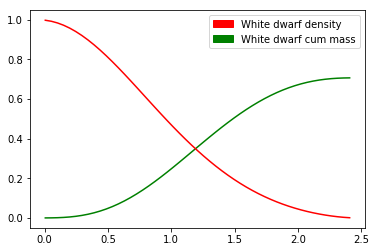

In [9]:
dr = 0.33333*((0.003/dwarf_parameter) ** 0.333333)#0.001
r0 = dr / 10.0
r1 = dr * 1000000

m_r0 = dwarf_parameter/3.0*(r0 ** 3)
po_r0 = dwarf_parameter - (dwarf_parameter ** 2)*(r0 ** 2) / (6.0*gamma(np.power(dwarf_parameter, 1.0/3.0)))
y_r0 = np.array([m_r0, po_r0], dtype=np.float32)

print(po_c, dr, y_r0)

dwarf_solution = differential_solver(f=differential_system_function,
                                     t0=r0, y0=y_r0, t1=r1, dt=dr,
                                     step_fn=runge_kutta_step,
                                     stop_condition=differential_system_stop_condition)

steps_count = np.shape(dwarf_solution)[0]
r = r0 + np.arange(steps_count)*dr

print("----- Dimesionless ------")
print("White dwarf mass: {}".format(dwarf_solution[-1, 0]))
print("White dwarf radius: {}".format(r0 + (steps_count - 1)*dr))

red_patch = mpatches.Patch(color='red', label='White dwarf density')
green_patch = mpatches.Patch(color='green', label='White dwarf cum mass')
plt.legend(handles=[red_patch, green_patch])
plt.plot(r, dwarf_solution[:, 0], 'g')
plt.plot(r, dwarf_solution[:, 1], 'r')
plt.show()

In [10]:
def compute_dwarfs(dimensionless_center_density_array):
    
    radius_array = []
    mass_array = []
    density_array = []
    
    for d0 in dimensionless_center_density_array:
        
        dr = (1.0/3.0)*((0.003/d0) ** (1.0/3.0))/10
        r0 = dr / 10
        r1 = dr * 1000000

        m_r0 = d0*(r0 ** 3) / 3.0
        po_r0 = d0 - (d0 ** 2)*(r0 ** 2) / (6.0*gamma(np.power(d0, 1.0/3.0)))
        y_r0 = np.array([m_r0, po_r0], dtype=np.float32)

        dwarf_solution = differential_solver(f=differential_system_function,
                                             t0=r0, y0=y_r0, t1=r1, dt=dr,
                                             step_fn=runge_kutta_step,
                                             stop_condition=differential_system_stop_condition)

        steps_count = np.shape(dwarf_solution)[0]
        r = r0 + np.arange(steps_count)*dr
        m = dwarf_solution[:, 0]
        po = dwarf_solution[:, 1]
        
        radius_array.append(r)
        mass_array.append(m)
        density_array.append(po)
    
    return radius_array, mass_array, density_array

In [11]:
dimensionless_center_density_array = 1e-6*np.exp(np.arange(60)*0.6931471806)
radius_array, mass_array, density_array = compute_dwarfs(dimensionless_center_density_array)

po = dimensionless_center_density_array
m = np.array([mass[-1] for mass in mass_array], dtype=np.float32)
r = np.array([radius[-1] for radius in radius_array], dtype=np.float32)

print("Min parameter: {}, Max parameter: {}".format(np.min(po), np.max(po)))
print("Min radius: {}, Max raduis: {}".format(np.min(r), np.max(r)))
print("Min mass: {}, Max mass: {}".format(np.min(m), np.max(m)))

Min parameter: 1e-06, Max parameter: 576460753665.7303
Min radius: 0.0008272483828477561, Max raduis: 25.047067642211914
Min mass: 0.0009593558497726917, Max mass: 2.0182340145111084


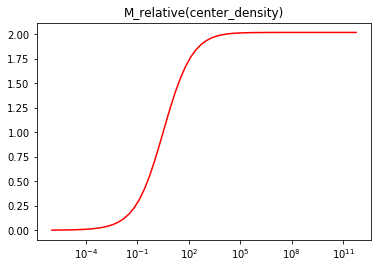

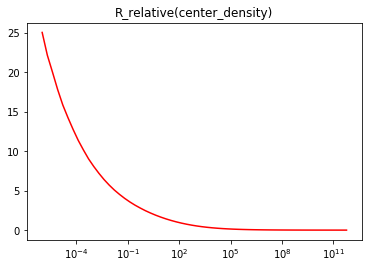

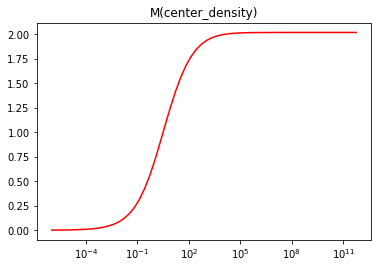

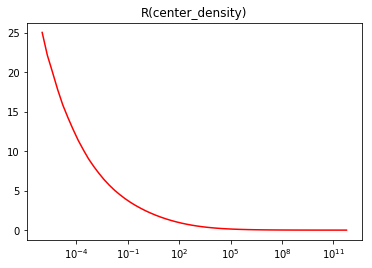

In [12]:
plt.figure()
plt.title("M_relative(center_density)")
plt.xscale('log')
plt.plot(po, m, 'r')
plt.show()

plt.figure()
plt.title("R_relative(center_density)")
plt.xscale('log')
plt.plot(po, r, 'r')
plt.show()

print("\n\n\n", end='')

plt.figure()
plt.title("M(center_density)")
plt.xscale('log')
plt.plot(po, m, 'r')
plt.show()

plt.figure()
plt.title("R(center_density)")
plt.xscale('log')
plt.plot(po, r, 'r')
plt.show()